In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from google.colab import drive

###Mount google Drive###

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Read and Select COVID-19 Records for india and fill null values with zeros###

In [3]:
df = pd.read_csv('/content/drive/My Drive/Datasets/owid-covid-data.csv')
df['date'] = pd.to_datetime(df['date'])
df.index = df.date
#df=df[(df['continent']=='Asia') & (df['location']=='India')][['date','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality']]
df=df[(df['continent']=='Asia') & (df['location']=='India') & (df['date']<'01/01/2022')][['date','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality']]
df.fillna(0, inplace=True)
df = df[['date','new_cases','new_deaths','new_tests','icu_patients','hosp_patients']]
#df['date'] = pd.to_datetime(df['date'])
#df.index = df.date

df.tail()

,date,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,,
2021-12-27,2021-12-27,6358.0,293.0,939539.0,0.0,0.0
2021-12-28,2021-12-28,9195.0,302.0,1141910.0,0.0,0.0
2021-12-29,2021-12-29,13154.0,268.0,1167612.0,0.0,0.0
2021-12-30,2021-12-30,16764.0,220.0,1199252.0,0.0,0.0
2021-12-31,2021-12-31,22775.0,406.0,1432860.0,0.0,0.0


Searcing for non-numeric rows

In [4]:
#pd.to_numeric(df['new_cases'], errors='coerce').notnull().all()
#pd.to_numeric(df['positive_rate'], errors='coerce').notnull().all()
#pd.to_numeric(df['new_deaths'], errors='coerce').notnull().all()
#pd.to_numeric(df['new_tests'], errors='coerce').notnull().all()
#pd.to_numeric(df['icu_patients'], errors='coerce').notnull().all()
#pd.to_numeric(df['hosp_patients'], errors='coerce').notnull().all()
df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

date             True
new_cases        True
new_deaths       True
new_tests        True
icu_patients     True
hosp_patients    True
dtype: bool

Convert float64 to int64 in panda series

In [5]:
df['new_cases'] = df['new_cases'].astype('Int64')
df['new_deaths'] = df['new_deaths'].astype('Int64')
df['new_tests'] = df['new_tests'].astype('Int64')
df['icu_patients'] = df['icu_patients'].astype('Int64')
df['hosp_patients'] = df['hosp_patients'].astype('Int64')

First 5 tuples of the Data Frame

In [6]:
df.head()

,date,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,,
2020-01-30,2020-01-30,1,0,0,0,0
2020-01-31,2020-01-31,0,0,0,0,0
2020-02-01,2020-02-01,0,0,0,0,0
2020-02-02,2020-02-02,1,0,0,0,0
2020-02-03,2020-02-03,1,0,0,0,0


Last 5 tuples of the Data Frame 

In [7]:
df.tail()

,date,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,,
2021-12-27,2021-12-27,6358,293,939539,0,0
2021-12-28,2021-12-28,9195,302,1141910,0,0
2021-12-29,2021-12-29,13154,268,1167612,0,0
2021-12-30,2021-12-30,16764,220,1199252,0,0
2021-12-31,2021-12-31,22775,406,1432860,0,0


#### Check the dimension of the data ####

In [8]:
df.shape

(702, 6)

###-Train-Test Splitting-###
####*Remember here we can’t shuffle the data, because it is a timeseries data so we have to follow the order!*####

In [9]:
df = df[['new_cases','new_deaths','new_tests','icu_patients','hosp_patients']]
test_split=round(len(df)*0.20)
print(len(df)-test_split)
df_for_training=df[:(len(df)-test_split)]
df_for_testing=df[(len(df)-test_split):]
print(df_for_training.shape)
print(df_for_testing.shape)


562
(562, 5)
(140, 5)


First 5 Records of the training data

In [10]:
df_for_training.head()

,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,
2020-01-30,1,0,0,0,0
2020-01-31,0,0,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,1,0,0,0,0
2020-02-03,1,0,0,0,0


Last 5 Records of the testing data

In [11]:
df_for_testing.tail()

,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,
2021-12-27,6358,293,939539,0,0
2021-12-28,9195,302,1141910,0,0
2021-12-29,13154,268,1167612,0,0
2021-12-30,16764,220,1199252,0,0
2021-12-31,22775,406,1432860,0,0


If you see the data, we can notice that the data range is very high, and they are not scaled in a same range, so to avoid prediction errors let’s scale the data first using MinMaxScaler.

In [12]:
#print(df['date'].dtype)
#print(df['new_cases'].dtype)
#print(df['new_deaths'].dtype)
#print(df['new_tests'].dtype)
#print(df['icu_patients'].dtype)
#print(df['hosp_patients'].dtype)


scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled


array([[2.41436256e-06, 2.20750552e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.20750552e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.20750552e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       ...,
       [9.94596657e-02, 1.08388521e-01, 4.75353288e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.68642259e-02, 1.29359823e-01, 6.18584465e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.33561571e-02, 1.05739514e-01, 5.61608760e-01, 0.00000000e+00,
        0.00000000e+00]])

Split the data in X and Y

In [13]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
    
trainX, trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

Verify TrainX, TrainY Shape

In [14]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (532, 30, 5)
trainY Shape--  (532,)


Verify TestX, TestY Shape

In [15]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (110, 30, 5)
testY Shape--  (110,)


Let’s have a look on one of the array containing (30,5) data from trainX and trainY value for that trainX array

In [16]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[2.41436256e-06 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.41436256e-06 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.41436256e-06 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.2075055

Now lets train the model , I used girdsearchCV to do some hyperparameter tuning to find the based model.

In [17]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
    
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model, param_grid = parameters, cv = 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  # Remove the CWD from sys.path while we load stuff.


Now let’s fit the model in out **trainX** and **trainY** data.

In [18]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/8
17/17 [==============================] - 5s 80ms/step - loss: 0.0302 - val_loss: 0.0036
Epoch 2/8
17/17 [==============================] - 0s 28ms/step - loss: 0.0098 - val_loss: 0.0024
Epoch 3/8
17/17 [==============================] - 0s 29ms/step - loss: 0.0053 - val_loss: 4.2990e-04
Epoch 4/8
17/17 [==============================] - 0s 28ms/step - loss: 0.0039 - val_loss: 8.4449e-04
Epoch 5/8
17/17 [==============================] - 0s 28ms/step - loss: 0.0035 - val_loss: 8.8468e-04
Epoch 6/8
17/17 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 6.1015e-04
Epoch 7/8
17/17 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 6.5771e-04
Epoch 8/8
17/17 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 1/8
17/17 [==============================] - 4s 75ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 2/8
17/17 [==============================] - 0s 28ms/step - loss: 6.5736e-04 - val_loss: 0.0024
Epoch 3/8
17/17 

Let's check best parameters of our LSTM Model

In [19]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}

Now, save the best model in my_model variable

In [20]:
my_model=grid_search.best_estimator_.model

We created our model to do the predictions for time series.
Now let’s test the model with our test data set.

In [21]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.11227634]
 [0.10772186]
 [0.10304048]
 [0.09886151]
 [0.09551954]
 [0.09343971]
 [0.09196029]
 [0.09092931]
 [0.09021086]
 [0.08973996]
 [0.08886879]
 [0.08844249]
 [0.08830991]
 [0.08767549]
 [0.08698859]
 [0.08596167]
 [0.08463504]
 [0.08203741]
 [0.07991524]
 [0.07781944]
 [0.0757488 ]
 [0.07393201]
 [0.07299422]
 [0.07202211]
 [0.07072057]
 [0.06804847]
 [0.06593982]
 [0.06414454]
 [0.06245241]
 [0.06094684]
 [0.05884939]
 [0.0571462 ]
 [0.05621786]
 [0.05509005]
 [0.05413167]
 [0.05287419]
 [0.05156662]
 [0.05005511]
 [0.04853018]
 [0.04730956]
 [0.04814079]
 [0.04930697]
 [0.04987152]
 [0.05022277]
 [0.0506881 ]
 [0.05128999]
 [0.05178005]
 [0.05081988]
 [0.04897708]
 [0.04560727]
 [0.04301523]
 [0.04019239]
 [0.03789059]
 [0.03521569]
 [0.03412523]
 [0.03359044]
 [0.03254881]
 [0.03071258]
 [0.0293733 ]
 [0.02788267]
 [0.02685473]
 [0.02704294]
 [0.0264718 ]
 [0.02460494]
 [0.0236781 ]
 [0.02333918]
 [0.02389175]
 [0.02486463]
 [0.02549995]
 [0.02590511]
 [0.0258

Now, the Inverse scaling is little bit tricky, let’s try it through code

In [22]:
scaler.inverse_transform(prediction)

ValueError: ignored

So, we have to change shape to use inverse_transform

In [23]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

check the shape now

In [24]:
prediction_copies_array.shape

(110, 5)

Now we can easily use inverse_transform function

In [25]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

We just need the first column after inverse transform, so we used → [:,0] at the end.
Now we need to compare this pred values with testY. But our testY is also scaled. So, let’s use inverse transform with the same above codes.

In [26]:
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

Now let’s check the prediction and original values →

In [27]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [46503.51   44617.1    42678.13   40947.25   39563.047  38701.61
 38088.848  37661.83   37364.254  37169.215  36808.387  36631.816
 36576.902  36314.137  36029.63   35604.293  35054.82   33978.91
 33099.934  32231.877  31374.244  30621.75   30233.328  29830.693
 29291.611  28184.86   27311.482  26567.896  25867.037  25243.45
 24374.709  23669.27   23284.766  22817.639  22420.69   21899.854
 21358.277  20732.225  20100.62   19595.05   19939.336  20422.354
 20656.186  20801.668  20994.404  21243.7    21446.676  21048.984
 20285.72   18889.984  17816.393  16647.205  15693.828  14585.917
 14134.262  13912.759  13481.325  12720.78   12166.07   11548.667
 11122.909  11200.863  10964.301  10191.069   9807.184   9666.81
  9895.676  10298.631  10561.773  10729.587  10724.564  10784.718
 11117.602  11115.299  11261.139  11285.995  11476.344  11074.562
 10566.053  10073.749   9861.048   9721.035   9551.142   8109.5957
 11361.364  12420.006  11892.466  10476.206   8922.694   7494.63

**Now let’s make a plot to check our pred and original data.**

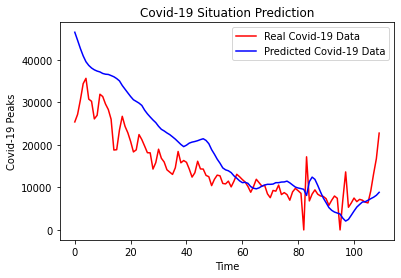

In [28]:
plt.plot(original, color = 'red', label = 'Real Covid-19 Data')
plt.plot(pred, color = 'blue', label = 'Predicted Covid-19 Data')
plt.title('Covid-19 Situation Prediction')
plt.xlabel('Time')
plt.ylabel('Covid-19 Peaks')
plt.legend()
plt.show()

Till now we trained our model, checked that model with test values.
> **Let’s now predict some future values.**

Now let’s take the last 30 values from the main ***df*** dataset what we loaded at the beginning

[Why 30? because that’s the number of past values we want, to predict the 31st value]

In [29]:
df_30_days_past=df.iloc[-30:,:]
df_30_days_past.tail()

,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,
2021-12-27,6358,293,939539,0,0
2021-12-28,9195,302,1141910,0,0
2021-12-29,13154,268,1167612,0,0
2021-12-30,16764,220,1199252,0,0
2021-12-31,22775,406,1432860,0,0


***We can see above that we have all the columns including target column "new_cases".***

> Now let’s predict future 30 values.

> [It is to be observed that in multivariate time series forecasting if we want to predict single column by using different features, while doing the prediction we need the feature values**(except the target column)** to do the upcoming predictions.]

**So ,** here we need the upcoming 30 values of **'new_cases', 'new_deaths', 'new_tests', 'icu_patients', 'hosp_patients'** columns to do the prediction of the **“new_cases”** column.



In [30]:
d=pd.read_csv('/content/drive/My Drive/Datasets/owid-covid-data.csv', usecols=['date','continent','location','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality'], low_memory=False) #,parse_dates=["date"],index_col=[3], usecols=['date','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality'], low_memory=False
df_30_days_future=d
df_30_days_future['date'] = pd.to_datetime(df_30_days_future['date'])
df_30_days_future.index = df_30_days_future.date

df_30_days_future=d[(d['continent']=='Asia') & (d['location']=='India') & (d['date']>'31/12/2021')]

#df_30_days_future = df_30_days_future[['date','new_cases','new_deaths','new_tests','icu_patients','hosp_patients']]
#df_30_days_future['date'] = pd.to_datetime(df_30_days_future['date'])
#df_30_days_future.index = df_30_days_future.date

df_30_days_future = df_30_days_future[['new_deaths','new_tests','icu_patients','hosp_patients']] #'new_cases',
df_30_days_future.fillna(0, inplace=True)

#df_30_days_future['new_cases'] = df_30_days_future['new_cases'].astype('Int64')

df_30_days_future['new_deaths'] = df_30_days_future['new_deaths'].astype('Int64')
df_30_days_future['new_tests'] = df_30_days_future['new_tests'].astype('Int64')
df_30_days_future['icu_patients'] = df_30_days_future['icu_patients'].astype('Int64')
df_30_days_future['hosp_patients'] = df_30_days_future['hosp_patients'].astype('Int64')



First 5 records of 30 days future prediction records

In [31]:
df_30_days_future.head()

,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,
2022-01-01,284,1110855,0,0
2022-01-02,123,1082376,0,0
2022-01-03,124,878990,0,0
2022-01-04,534,1478119,0,0
2022-01-05,325,1388647,0,0


Last 5 records of 30 days future prediction records

In [32]:
df_30_days_future.tail()

,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,
2022-01-26,573,1769745,0,0
2022-01-27,627,1594070,0,0
2022-01-28,871,1582307,0,0
2022-01-29,893,0,0,0
2022-01-30,959,0,0,0


Now we have to do some steps before doing the prediction using our model →
    
    1) We have to scale the past and future data. As you can see in our future data we don’t have “new_cases” column , so before scaling it , just add a “new_cases” column in the future data with all “0” values.
    
    2) After scaling replace the “new_cases” column value with “nan” in the future data
    
    3) Now attach the 30 days old value with 30 days new value (where last 30 “new_cases” values are nan)

In [33]:
df_30_days_future["new_cases"]=0
df_30_days_future=df_30_days_future[['new_cases','new_deaths','new_tests','icu_patients','hosp_patients']]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

Now check the **full_df**. The shape will be **(60,5)** with ***30 NaN*** values for the first column at the end.

In [34]:
full_df

,0,1,2,3,4
0,0.022251,0.086534,0.293723,0.0,0.0
1,0.020771,0.091832,0.309376,0.0,0.0
2,0.000000,0.000221,0.363261,0.0,0.0
3,0.041529,0.664018,0.327799,0.0,0.0
4,0.016471,0.048786,0.269021,0.0,0.0
5,0.020375,0.043267,0.317608,0.0,0.0
6,0.022741,0.035320,0.324341,0.0,0.0
7,0.020285,0.081457,0.344888,0.0,0.0
8,0.019291,0.086976,0.345805,0.0,0.0
9,0.019018,0.124283,0.369960,0.0,0.0


**Now,** to do the prediction we have to use the for loop again, what we made while spliting the data in **trainX** and **trainY**. But this time we have only ***X***, no ***Y*** value is there:

In [35]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In the the above code for the first prediction we have previous 30 values. Which means, when the for loop run for the first time, it checked the previous 30 values and predict the 31st **“new_cases”** data.

**But** when the 2nd for loop will try to run, it will skip first row and try to get next 30 values means [1:31] , here we will start getting error as in the last row for the open column we have **“NaN”**, so we have replace the **“NaN”** with the prediction each time.

**Now,** let’s do the inverse transform on our prediction to check the real value like we did before →

In [36]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]
Future_list_30days=y_pred_future_30_days.tolist()
print('30 days prediction:')
for i in Future_list_30days:
  print(i)

30 days prediction:
10152.158203125
11481.0810546875
12516.474609375
13613.6875
14371.99609375
15172.822265625
15707.890625
16087.1708984375
16309.62890625
16339.4775390625
16544.25390625
16486.5703125
17019.63671875
19031.0546875
22492.251953125
24245.34375
25170.158203125
26091.7734375
26928.248046875
27445.859375
28348.265625
28910.01171875
29683.498046875
30437.6953125
32094.828125
33879.31640625
35638.140625
37659.05078125
40177.0625
44640.796875


#Thus, We predicted 30 future values….